# 図 9.4 の生成（アルゴリズム 9.1）

In [ ]:
! pip install POT

In [ ]:
! mkdir "imgs" -p
! mkdir "imgs/gw" -p
for i in range(112):
  ! wget "https://github.com/joisino/otbook/raw/main/notebooks/imgs/gw/{i}.png" -O "imgs/gw/{i}.png"
! wget "https://github.com/joisino/otbook/raw/main/notebooks/imgs/shape.png" -O "imgs/shape.png"

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.metrics import pairwise_distances
import ot

In [2]:
li = []
for i in os.listdir('./imgs/gw'):
    img = Image.open('./imgs/gw/' + i) # 画像の読み込み
    w, h = img.size

    # アスペクト比 4:3 に切り取り
    if 3 * w > 4 * h:
        margin = (w - 4 * h / 3) / 2
        img = img.crop((margin, 0, w - margin, h))
    else:
        margin = (h - 3 * w / 4) / 2
        img = img.crop((0, margin, w, h - margin))
    
    w, h = img.size
    r = np.sqrt((80 * 60) / (w * h))
    nw, nh = int(w * r), int(h * r)
    img = img.resize((nw, nh)) # 画像のリサイズ
    img = img.convert('RGB')
    li.append(img)
img_w, img_h = li[0].size

In [3]:
img = Image.open('./imgs/shape.png') # OT-シェイプを読み込み
shape_w, shape_h = img.size
img

In [4]:
X = list(zip(*np.where(np.array(img)[:, :, 0] < 128))) # OT-シェイプを座標の集合に変換
n = len(X)

In [5]:
# 幅優先探索により OT-シェイプの測地線距離を計算
dx = [1, 0, -1, 0]
dy = [0, -1, 0, 1]

dX = np.zeros((n, n))
for i in range(n):
    que = [i]
    used = [False for i in range(n)]
    used[i] = True
    while len(que) > 0:
        j = que.pop(0)
        for k in range(4):
            ny = X[j][0] + dy[k]
            nx = X[j][1] + dx[k]
            if (ny, nx) in X:
                ni = X.index((ny, nx))
                if not used[ni]:
                    used[ni] = True
                    dX[i, ni] = dX[i, j] + 1
                    que.append(ni)
dX /= dX.max() # 最大距離が 1 になるように正規化

In [6]:
# 画像どうしの距離を計算
Y = np.array([np.array(img).reshape(-1, 3).mean(0) for img in li])
dY = pairwise_distances(Y)
dY /= dY.max()

In [7]:
# アルゴリズム 9.1
eps = 0.003
lam = 0.003
a = np.ones(n) / n
b = np.ones(n) / n
P = np.ones((n, n)) / (n * n)
v = np.ones(n) # すべて 1 で初期化
for i in range(1000):
    C = - 4 * dX @ P @ dY + (eps - lam) * np.log(P)
    K = np.exp(- C / lam)
    
    while True:
        u = a / (K @ v)
        v = b / (K.T @ u)
        P = u.reshape(n, 1) * K * v.reshape(1, n)
        if np.abs(P.sum(1) - a).sum() < 1e-6 and np.abs(P.sum(0) - b).sum() < 1e-6:
            break

In [8]:
res = ot.emd(a, b, -C) # 一対一対応を計算

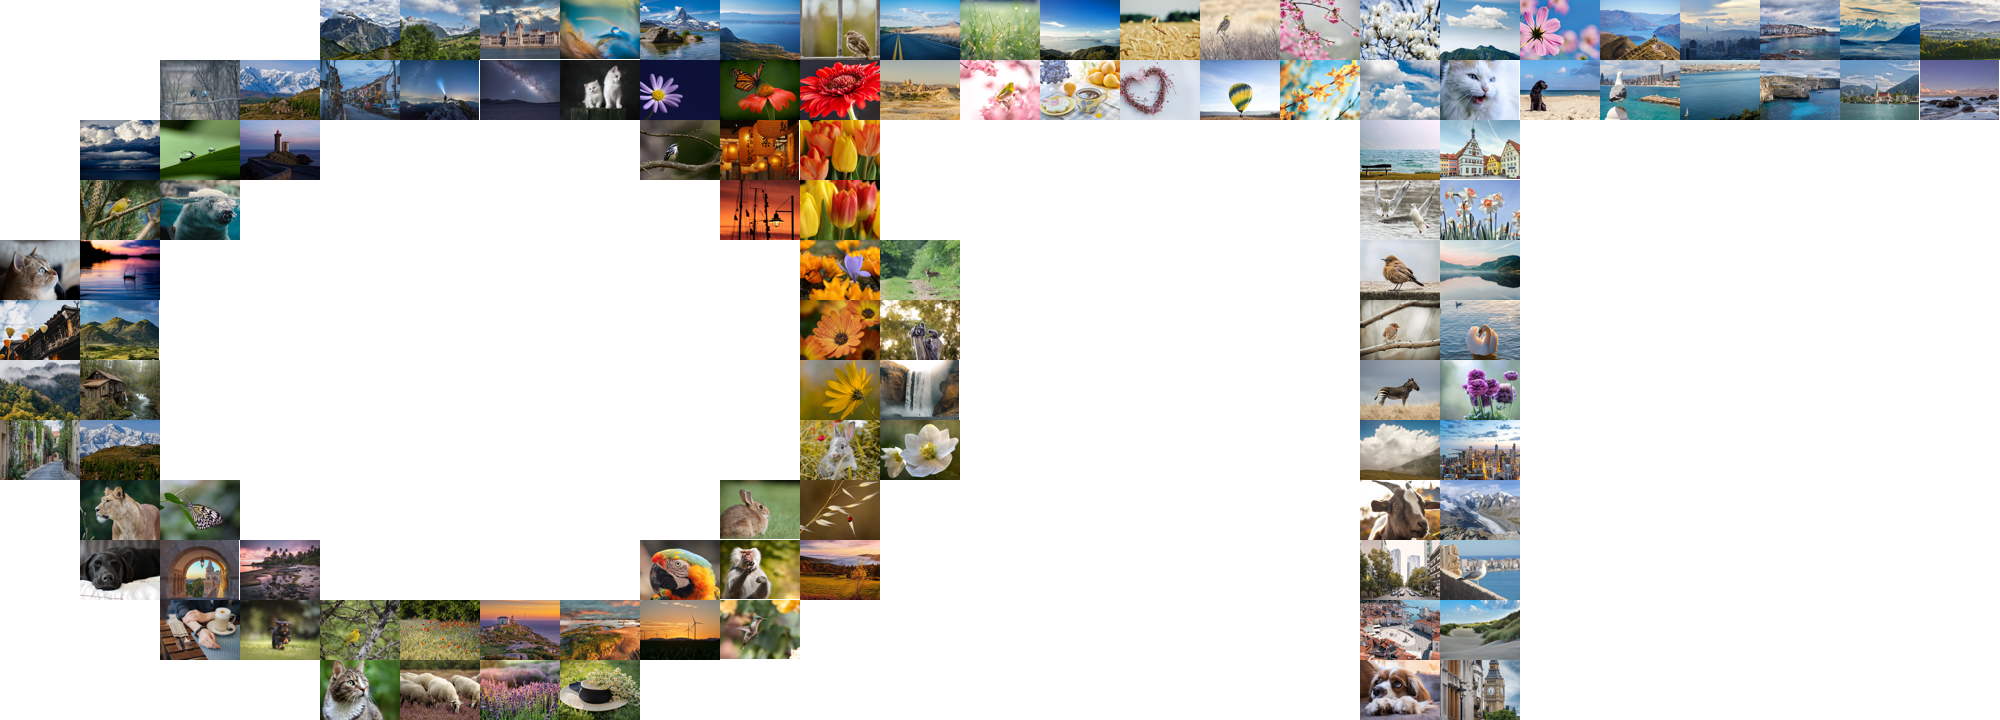

In [9]:
img = Image.new('RGB', (img_w * shape_w, img_h * shape_h), 'white')
for i in range(n):
    j = res[:, i].argmax()
    img.paste(li[i], (X[j][1] * img_w, X[j][0] * img_h))
img